# Parallel Raster Block Processing

This tutorial will explain the usage of classes from `eumap.parallel.blocks` for analysis of raster data within a bounding geometry.

First we will define a simplified bounding geometry of Plitvice Lakes National Park in Croatia and define a raster path (url) which will be used both as the reference raster for `RasterBlockReader` and in further analysis. For this purpose we will use the GeoHarmonizer landcover data for 2019.

In [1]:
# To work with local eumap code
# import sys
# sys.path.append('../../')

from skmap.misc import ttprint
from skmap.parallel.blocks import RasterBlockReader, RasterBlockAggregator, RasterBlockWriter
import numpy as np
from skmap import plotter

geom = {
    'type': 'Polygon',
    'coordinates': [[
        [4765389, 2441103],
        [4764441, 2439352],
        [4767369, 2438696],
        [4771350, 2436416],
        [4772117, 2435102],
        [4771548, 2435471],
        [4771966, 2434464],
        [4769538, 2431016],
        [4772032, 2428380],
        [4771939, 2423031],
        [4769843, 2423438],
        [4766018, 2420238],
        [4764154, 2420669],
        [4757231, 2425572],
        [4756108, 2429277],
        [4754450, 2431661],
        [4755250, 2434051],
        [4754203, 2436641],
        [4752352, 2437575],
        [4751935, 2439219],
        [4753281, 2441053],
        [4756079, 2441538],
        [4755741, 2442636],
        [4758266, 2444223],
        [4761659, 2441949],
        [4765389, 2441103],
    ]],
}

fp = 'https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_landcover.hcl_lucas.corine.rf_p_30m_0..0cm_2019_eumap_epsg3035_v0.1.tif'

Next, we will initialize our reader, which serves to optimize block-by-block reading of large rasters. For large files this might take a few seconds.

In [2]:

ttprint('initializing reader')

reader = RasterBlockReader(fp)

ttprint('reader initialized')

[16:05:34] initializing reader
[16:05:35] reader initialized


## Aggregation of values within a bounding geometry

Now we can initialize our `RasterBlockAggregator`, define a function that calculates the area of all pixels corresponding to _urban fabric_ and run it across the bounding geometry.

The processing function can produce pixel-wise results, as the `agg` will take care of sumation.

Furthermore, when doing this we can choose to omit the geometry mask, which causes the function to be run accross all raster blocks which touch the bounding geometry. This provides a speedup for large geometries but can also produce very different results.

In [3]:

agg = RasterBlockAggregator(reader)

def urban_fabric_area(lc):
    return (lc==1) * 9e-4 # spatial resolution is 30x30 m

ttprint('aggregating with geometry mask')

result = agg.aggregate(
    fp, geom,
    block_func=urban_fabric_area,
    agg_func=np.sum,
)

ttprint('result:', result, 'km2')

ttprint('aggregating without geometry mask')

result = agg.aggregate(
    fp, geom,
    block_func=urban_fabric_area,
    agg_func=np.sum,
    geometry_mask=False,
)

ttprint('result:', result, 'km2')

[16:05:35] aggregating with geometry mask
reader using 3 threads
[16:05:36] result: 0.5309999999999999 km2
[16:05:36] aggregating without geometry mask
reader using 3 threads
[16:05:36] result: 22.581000000000007 km2


## Producing processed raster output within a bounding geometry

Next, we will produce a mask of all pixels that correspond to _urban fabric_ within our geometry. As above, we can omit the geometry mask for faster, but different, results. We will show the results using `eumap.plotter`.

[16:05:36] writing with geometry mask
reader using 3 threads
[16:05:37] done
[16:05:37] writing without geometry mask
reader using 3 threads
[16:05:37] done


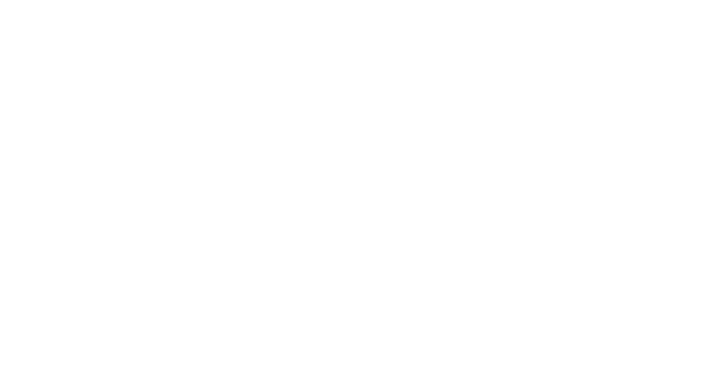

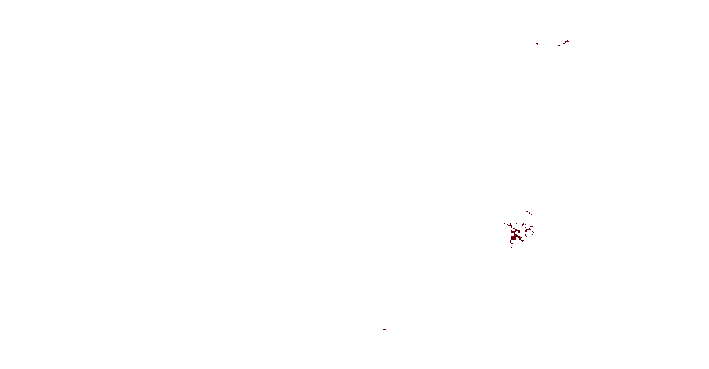

In [4]:

def is_urban_fabric(lc):
    return lc == 1

writer = RasterBlockWriter(reader)

ttprint('writing with geometry mask')
writer.write(fp, 'urban_fabric_mask.tif', geom, is_urban_fabric, dtype='uint8', nodata=0)

ttprint('done')

plotter.plot_rasters(
    'urban_fabric_mask.tif',
    cmaps='Reds',
    figsize=6,
)

ttprint('writing without geometry mask')
writer.write(fp, 'urban_fabric_nomask.tif', geom, is_urban_fabric, geometry_mask=False, dtype='uint8', nodata=0)

ttprint('done')

plotter.plot_rasters(
    'urban_fabric_nomask.tif',
    cmaps='Reds',
    figsize=6,
)

We can also process an arbitrary number of rasters at the same time. To demonstrate this, we will calculate NDVI within the bounding geometry using the red and NIR LANDSAT bands.

[16:05:38] writing with geometry mask
reader using 3 threads
[16:05:39] done
[16:05:39] writing without geometry mask
reader using 3 threads
[16:05:40] done


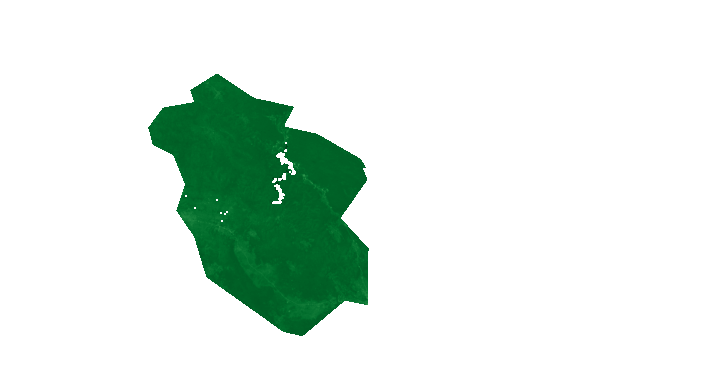

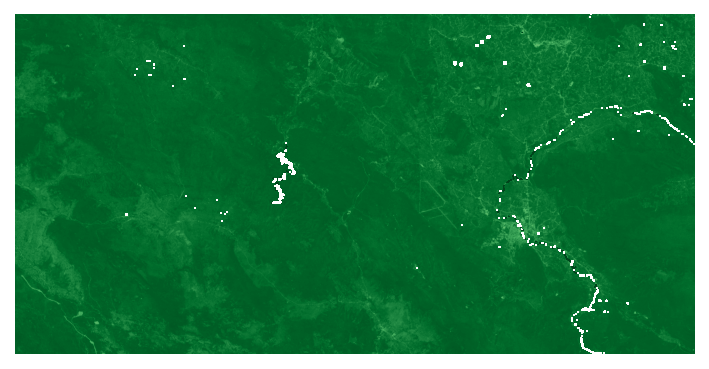

In [5]:

def ndvi(red, nir):
    return (nir - red) / (nir + red)

fp = [
    'http://s3.eu-central-1.wasabisys.com/eumap/landsat/landsat_ard_20180625_20180912_red_p50.tif',
    'http://s3.eu-central-1.wasabisys.com/eumap/landsat/landsat_ard_20180625_20180912_nir_p50.tif',
]

ttprint('writing with geometry mask')
writer.write(fp, 'ndvi_mask.tif', geom, ndvi, dtype='float32', nodata=-9999)

ttprint('done')

plotter.plot_rasters(
    'ndvi_mask.tif',
    cmaps='Greens',
    figsize=6,
    vmin=-1,
    vmax=1,
)

ttprint('writing without geometry mask')
writer.write(fp, 'ndvi_nomask.tif', geom, ndvi, geometry_mask=False, dtype='float32', nodata=-9999)

ttprint('done')

plotter.plot_rasters(
    'ndvi_nomask.tif',
    cmaps='Greens',
    figsize=6,
    vmin=-1,
    vmax=1,
)
